In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
from Data import GraphDataset
from Models import GCNFeatureExtractor
from utils.train import train

In [3]:
use_pre_paired = True
learning_rate = 1e-4
epochs = 2500
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_size = 100
pooling = 'global_avg'
temperature = 0.5
patience = 1000
alpha = 0.01

In [4]:
# load data 
from Data import load_graphs

basic_data, _ = load_graphs()

	Collected 1 sample from null_ops.
	Collected 4 samples from commutations.
	Collected 7 samples from equivalences.
	Collected 7 samples from combined.
Loaded 19 samples and 19 quantum circuits from subset.


## Basic transforms training

In [5]:
from sklearn.model_selection import train_test_split
test_mask = torch.zeros(len(basic_data), dtype=torch.bool)
test_mask[12:14] = True
val_mask = torch.zeros(len(basic_data), dtype=torch.bool)
val_mask[14:17] = True

train_data = [basic_data[i] for i in range(len(basic_data)) if not test_mask[i] and not val_mask[i]]
val_data = [basic_data[i] for i in range(len(basic_data)) if val_mask[i]]
test_data = [basic_data[i] for i in range(len(basic_data)) if test_mask[i]]

# train_data, val_data = train_test_split(train_data, train_size=0.8, shuffle=True)
print('Data split:')
print('train:', len(train_data), '(', round((len(train_data) / len(basic_data)) * 100, 1), '%)')
print('val:', len(val_data), '(', round((len(val_data) / len(basic_data)) * 100, 1), '%)')
print('test:', len(test_data), '(', round((len(test_data) / len(basic_data)) * 100, 1), '%)')

train_dataset = GraphDataset(train_data, pre_paired=use_pre_paired)
val_dataset = GraphDataset(val_data, pre_paired=use_pre_paired)
test_dataset = GraphDataset(test_data, pre_paired=use_pre_paired)

Data split:
train: 14 ( 73.7 %)
val: 3 ( 15.8 %)
test: 2 ( 10.5 %)


In [6]:
batch_size = len(train_dataset)
print('Batch size:', batch_size)

Batch size: 14


In [7]:
graphs = basic_data[0]
print(len(graphs))

18


In [8]:
import numpy as np
import networkx as nx
def get_attr_matrix(graph):
    nodes_list = list(graph.nodes)
    nodes_view = graph.nodes(data=True)
    return np.array([nodes_view[node]['feature_vector'] for node in nodes_list])

In [9]:
# # Check if graphs in the dataset are correctly converted to PyTorch Geometric Data objects
# graphs = [basic_data[0][0:2]]
# dataset_1 = GraphDataset(graphs, pre_paired=use_pre_paired)

# data_1, data_2 = dataset_1[0]

# print("NODE FEATURES:")

# print(get_attr_matrix(graphs[0][0]))
# print(get_attr_matrix(graphs[0][1]))

# print("---")

# print(data_1.x)
# print(data_2.x)

# print("ADJACENCY:")

# print(nx.adjacency_matrix(graphs[0][0]).todense())
# print(nx.adjacency_matrix(graphs[0][1]).todense())

# print("---")

# print(data_1.edge_index)
# print(data_2.edge_index)

In [10]:
# create a fully connected nn stacking fully connected layers and ReLU activations
out_dim_gnn = embedding_size
proj_out_dim = 64

fc_model = torch.nn.Sequential(
    torch.nn.Linear(out_dim_gnn, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, proj_out_dim),
)



In [11]:
n_features = train_dataset[0][0].x.shape[1] if use_pre_paired else train_dataset[0].x.shape[1]
print(f'Number of features in the dataset: {n_features}')

gnn = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy=pooling)
proj = fc_model

# No projection head
from Models import CLWrapper
model = CLWrapper(gnn).to(device)

Number of features in the dataset: 6


In [12]:
taus = [0.1, 0.5]
history = {}
for temperature in taus:
    print(f'Temperature: {temperature}')

    history[f'{temperature}'] = train(model, train_dataset, val_dataset,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    lr=learning_rate,
                    tau= temperature, 
                    device=device, 
                    ema_alpha= alpha,
                    #patience= patience,
                    verbose= False)


# check ema by setting alpha to 0 (should be constant)

Temperature: 0.1


Training: 100%|██████████| 2500/2500 [02:24<00:00, 17.34epoch/s, loss=0.0158, val_loss=0.1662, ema_val_loss=0.4762]


Restoring model to the state with the best validation loss: 0.0005
Temperature: 0.5


Training: 100%|██████████| 2500/2500 [02:32<00:00, 16.44epoch/s, loss=1.4537, val_loss=1.1443, ema_val_loss=0.9316]

Restoring model to the state with the best validation loss: 0.3939


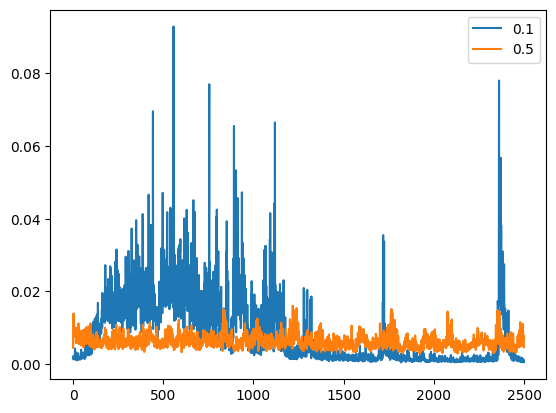

In [14]:
# plot avg_grad_norm_l1_per_param for each tau
import matplotlib.pyplot as plt

for tau in taus:
    plt.plot(history[f'{tau}']['avg_grad_norm_l1_per_param'], label=f'{tau}')
plt.legend()
plt.show()


In [13]:
# plot loss trend during training
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['ema_val_loss'], label='val loss (EMA)')
plt.legend()
plt.show

KeyError: 'train_loss'

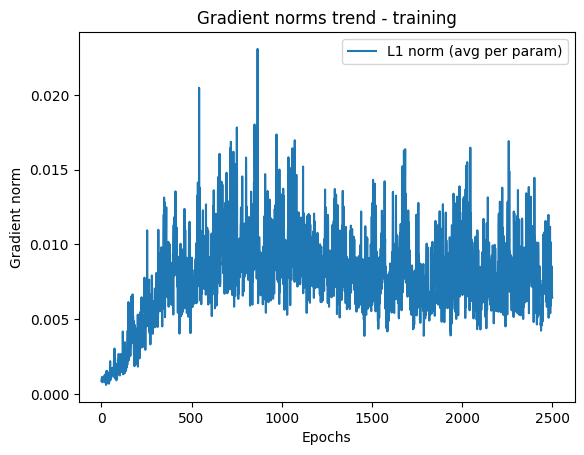

In [ ]:
#plt.plot(history['grad_norm_l2'], label='L2 norm')
plt.plot(history['avg_grad_norm_l1_per_param'], label='L1 norm (avg per param)')
plt.xlabel('Epochs')
plt.ylabel('Gradient norm')
plt.title('Gradient norms trend - training')
plt.legend()
plt.show()

In [ ]:
num_model_params = sum(p.numel() for p in model.parameters())
print(f'Number of model parameters: {num_model_params}')

Number of model parameters: 765484


In [29]:
# Now visualize what the model has learned
# Extract GNN
gnn_no_proj = model.gnn

pos1, pos2 = val_dataset[0]
neg1, neg2 = val_dataset[1]

# Extract embeddings
emb1 = gnn_no_proj(pos1)
emb2 = gnn_no_proj(pos2)

neg_emb1 = gnn_no_proj(neg1)
neg_emb2 = gnn_no_proj(neg2)

In [30]:
emb1

tensor([[-0.0144, -0.1033, -0.1307,  0.0957,  0.2346,  0.5731,  0.1315, -0.1649,
          0.0181, -0.1892, -0.2553,  0.1624, -0.0338,  0.4488,  0.6130, -0.2377,
         -0.2766,  0.1307, -0.0433, -0.4036, -0.0398, -0.5096,  0.1726,  0.0204,
          0.0073, -0.1552,  0.2498, -0.1442,  0.0534,  0.0440, -0.1411,  0.1077,
         -0.3970, -0.1730, -0.0458, -0.1200, -0.0638,  0.5729,  0.2028,  0.1262,
          0.1927,  0.3075,  0.1030, -0.0485, -0.3171,  0.1712,  0.1280,  0.3039,
          0.1885,  0.1261,  0.0441,  0.2973, -0.1478, -0.1907, -0.2047,  0.0112,
         -0.5800, -0.2618,  0.0163, -0.4805,  0.1231,  0.1948, -0.1715, -0.1531,
         -0.1693,  0.1932, -0.2066,  0.4017, -0.3312, -0.0563, -0.1501,  0.4534,
         -0.1215, -0.3028,  0.6773, -0.1342, -0.0558, -0.1746,  0.2423, -0.3177,
          0.0142,  0.2975, -0.1622, -0.1314, -0.2973,  0.1590, -0.2860, -0.0479,
          0.1332, -0.0782, -0.3130,  0.1321,  0.4053,  0.0716,  0.3384, -0.1539,
         -0.0111,  0.0869,  

In [31]:
emb2

tensor([[ 0.0073, -0.1483,  0.0315,  0.0716,  0.1303,  0.3906,  0.0413, -0.2890,
         -0.1109, -0.0576, -0.2151,  0.1673, -0.0330,  0.4281,  0.6056, -0.2996,
         -0.1847,  0.1095, -0.0864, -0.2839, -0.0788, -0.5295,  0.2025,  0.2298,
         -0.1462, -0.0149,  0.0949, -0.1338,  0.0826,  0.1908, -0.1611,  0.1871,
         -0.3123, -0.1364,  0.0491, -0.2813, -0.0319,  0.4866,  0.2179,  0.1117,
          0.1551,  0.2313,  0.0922,  0.0862, -0.1284,  0.1221,  0.0174,  0.1284,
          0.2971,  0.2334,  0.1361,  0.1824, -0.1316, -0.1337, -0.1167,  0.0986,
         -0.4315, -0.4369,  0.1842, -0.5683,  0.1374,  0.2255, -0.1820, -0.2442,
         -0.1204,  0.1235, -0.1584,  0.3071, -0.3700, -0.0161, -0.1244,  0.5247,
         -0.0709, -0.2524,  0.7808, -0.1324, -0.1015, -0.1668,  0.2426, -0.3246,
          0.0598,  0.1258, -0.2229, -0.1296, -0.2700,  0.0894, -0.1021, -0.0527,
          0.1314, -0.2188, -0.2632,  0.2505,  0.4086,  0.0970,  0.2725,  0.1022,
         -0.0177, -0.1321,  

In [32]:
neg_emb1

tensor([[ 0.0474, -0.0106,  0.0747,  0.0620,  0.3013,  0.0626, -0.3947,  0.0949,
         -0.0193,  0.2486,  0.1641,  0.1948, -0.2795,  0.2878,  0.0419, -0.3464,
          0.0072,  0.4600, -0.2345,  0.0814, -0.3194, -0.4088,  0.2318,  0.5878,
          0.0985,  0.2406, -0.2752,  0.0881, -0.0531,  0.3782,  0.2313,  0.1346,
         -0.3759, -0.2753,  0.1542, -0.1474, -0.2346,  0.5814,  0.2200,  0.3829,
         -0.1059, -0.0437,  0.1237,  0.3595,  0.3977,  0.7002, -0.0814, -0.0070,
          0.5655,  0.9140,  0.0057,  0.0755,  0.3470, -0.1020, -0.2087, -0.2036,
         -0.3397, -0.3850, -0.1565, -0.8062, -0.1045,  0.0457, -0.3856, -0.1176,
         -0.0134,  0.1353,  0.1192, -0.1419, -0.3257,  0.2462, -0.2113,  0.5073,
         -0.1157,  0.3354,  0.4821, -0.2580, -0.0120,  0.3232,  0.6442,  0.2864,
         -0.0224,  0.4213,  0.2579, -0.2831,  0.6465,  0.5845, -0.2427, -0.2141,
          0.0452, -0.2021, -0.5833, -0.0559,  0.0616,  0.2399, -0.2514, -0.0712,
         -0.1850, -0.0230, -

In [33]:
from utils.losses import NTXentLoss

print(f"Distance (L2 norm) among positive pair 1: {torch.norm(emb1 - emb2, dim=1).item()}")
print(f"Distance (L2 norm) among positive pair 2: {torch.norm(neg_emb1 - neg_emb2, dim=1).item()}")

print(f"Distance (L2 norm) among negative pair 1: {torch.norm(emb1 - neg_emb1, dim=1).item()}")
print(f"Distance (L2 norm) among negative pair 2: {torch.norm(emb2 - neg_emb2, dim=1).item()}")

Distance (L2 norm) among positive pair 1: 0.9540355801582336
Distance (L2 norm) among positive pair 2: 0.8587173819541931
Distance (L2 norm) among negative pair 1: 3.157410144805908
Distance (L2 norm) among negative pair 2: 2.341019630432129


In [34]:
# Now compute similarity between embeddings
from torch.nn.functional import cosine_similarity

print(f"Cosine similarity among positive pair 1: {cosine_similarity(emb1, emb2).item()}")
print(f"Cosine similarity among positive pair 2: {cosine_similarity(neg_emb1, neg_emb2).item()}")
print(f"Cosine similarity among negative pair 1: {cosine_similarity(emb1, neg_emb1).item()}")
print(f"Cosine similarity among negative pair 2: {cosine_similarity(emb2, neg_emb2).item()}")

Cosine similarity among positive pair 1: 0.9243980646133423
Cosine similarity among positive pair 2: 0.9734023809432983
Cosine similarity among negative pair 1: 0.37126606702804565
Cosine similarity among negative pair 2: 0.5417730808258057


In [35]:
# Show scores from NTXentLoss
ntxent = NTXentLoss(temperature)

z1 = torch.cat([emb1, neg_emb1], dim=0)
z2 = torch.cat([emb2, neg_emb2], dim=0)

loss, pos_score, neg_score = ntxent(z1, z2)

print(f"Loss: {loss.item()}")
print(f"Positive scores: {pos_score}")
print(f"Negative scores: {neg_score}")

Loss: 0.5730701088905334
Positive scores: tensor([[0.9244],
        [0.9734],
        [0.9244],
        [0.9734]], grad_fn=<ViewBackward0>)
Negative scores: tensor([[0.3713, 0.5073],
        [0.3713, 0.4616],
        [0.4616, 0.5418],
        [0.5073, 0.5418]], grad_fn=<ViewBackward0>)


### Now use a projector and do the same

In [36]:
gnn = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy=pooling)
model = CLWrapper(gnn, proj).to(device)

In [37]:
history = train(model, train_dataset, val_dataset,
                epochs=epochs, 
                batch_size=batch_size, 
                lr=learning_rate,
                tau= temperature, 
                device=device,
                ema_alpha= alpha,
                patience=patience, 
                verbose=False)

Training:   3%|▎         | 72/2500 [00:04<02:22, 17.10epoch/s, loss=2.4132, val_loss=1.5742, ema_val_loss=1.5220]


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

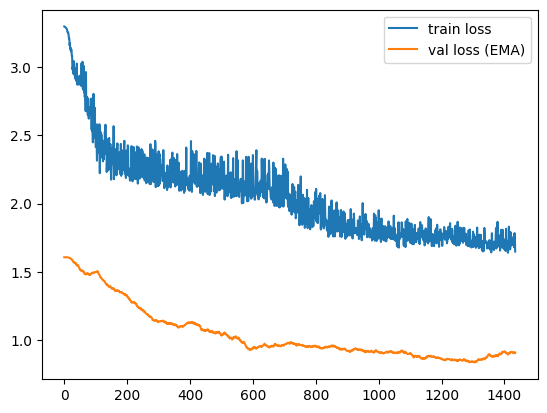

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['ema_val_loss'], label='val loss (EMA)')
plt.legend()
plt.show

KeyError: 'grad_norm_l1'

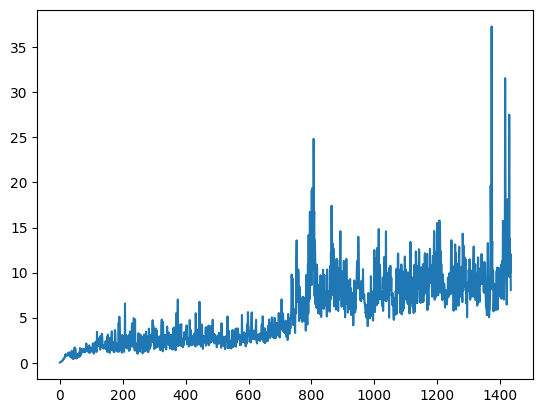

In [ ]:
plt.plot(history['grad_norm_l2'], label='L2 norm')
plt.plot(history['grad_norm_l1'], label='L1 norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient norm')
plt.title('Gradient norms trend - training')
plt.legend()
plt.show()

In [ ]:
gnn_proj = model.gnn

# Extract embeddings
emb1 = gnn_proj(pos1)
emb2 = gnn_proj(pos2)

neg_emb1 = gnn_proj(neg1)
neg_emb2 = gnn_proj(neg2)

In [ ]:
print(f"Distance (L2 norm) among positive pair 1: {torch.norm(emb1 - emb2, dim=1).item()}")
print(f"Distance (L2 norm) among positive pair 2: {torch.norm(neg_emb1 - neg_emb2, dim=1).item()}")

print(f"Distance (L2 norm) among negative pair 1: {torch.norm(emb1 - neg_emb1, dim=1).item()}")
print(f"Distance (L2 norm) among negative pair 2: {torch.norm(emb2 - neg_emb2, dim=1).item()}")

Distance (L2 norm) among positive pair 1: 0.059543438255786896
Distance (L2 norm) among positive pair 2: 1.3234156370162964
Distance (L2 norm) among negative pair 1: 1.5284698009490967
Distance (L2 norm) among negative pair 2: 1.2002485990524292


In [ ]:
print(f"Cosine similarity among positive pair 1: {cosine_similarity(emb1, emb2).item()}")
print(f"Cosine similarity among positive pair 2: {cosine_similarity(neg_emb1, neg_emb2).item()}")
print(f"Cosine similarity among negative pair 1: {cosine_similarity(emb1, neg_emb1).item()}")
print(f"Cosine similarity among negative pair 2: {cosine_similarity(emb2, neg_emb2).item()}")

Cosine similarity among positive pair 1: 0.9996548891067505
Cosine similarity among positive pair 2: 0.7840444445610046
Cosine similarity among negative pair 1: 0.7222697734832764
Cosine similarity among negative pair 2: 0.8466265797615051


In [ ]:
z1 = torch.cat([emb1, neg_emb1], dim=0)
z2 = torch.cat([emb2, neg_emb2], dim=0)

loss, pos_score, neg_score = ntxent(z1, z2)

print(f"Loss: {loss.item()}")
print(f"Positive scores: {pos_score}")
print(f"Negative scores: {neg_score}")

Loss: 0.9672967791557312
Positive scores: tensor([[0.9997],
        [0.7840],
        [0.9997],
        [0.7840]], grad_fn=<ViewBackward0>)
Negative scores: tensor([[0.7223, 0.8442],
        [0.7223, 0.7185],
        [0.7185, 0.8466],
        [0.8442, 0.8466]], grad_fn=<ViewBackward0>)


### Evaluate with Linear Evaluation

In [ ]:
# Get two classes from dataset
class_1 = test_data[0]
class_2 = test_data[1]

In [ ]:
class_1

In [ ]:
from Data.Dataset import from_nx_to_geometric
# create labels vector
labels = torch.cat([torch.zeros(len(class_1)), torch.ones(len(class_2))]).long()

# create samples
data = [from_nx_to_geometric(g) for g in class_1 + class_2]
print(len(data))

# Split data into training and test set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

# WITHOUT PROJECTION HEAD
X_train_no_proj = torch.cat([gnn_no_proj(d) for d in X_train])
X_test_no_proj = torch.cat([gnn_no_proj(d) for d in X_test])

# WITH PROJECTION HEAD
X_train_proj = torch.cat([gnn_proj(d) for d in X_train])
X_test_proj = torch.cat([gnn_proj(d) for d in X_test])

print(labels.shape)
print(X_train_proj.shape)
print(X_test_proj.shape)

10
torch.Size([10])
torch.Size([8, 100])
torch.Size([2, 100])


In [ ]:
print(X_train_proj)
print(X_train_no_proj)

tensor([[-4.9290e-02,  1.8114e-01,  2.6437e-01, -2.8551e-01, -5.3872e-01,
         -1.8553e-01, -8.8329e-02,  3.0592e-01,  2.1779e-01, -8.7415e-02,
         -2.0628e-01, -1.7847e-01, -1.8736e-01,  1.6675e-01,  9.2961e-02,
          4.5887e-02,  2.2364e-01, -4.1318e-02,  6.2891e-02,  1.3601e-02,
          6.5886e-02, -1.2585e-01, -2.1204e-01, -2.3266e-01,  1.5630e-02,
          2.4162e-01,  3.4347e-01, -1.9509e-01, -1.5745e-01, -4.7096e-02,
         -1.0396e-01, -1.4884e-01,  9.5537e-02, -2.3883e-01,  5.5823e-02,
         -1.8169e-02, -1.5314e-01,  2.7499e-02, -3.3993e-01,  3.4435e-02,
          1.8204e-01, -3.8829e-02, -2.0052e-01, -4.2855e-01, -2.2046e-01,
          2.4584e-02,  2.6287e-01,  7.1292e-02,  2.0389e-01,  1.2025e-01,
          1.9891e-01, -1.8034e-01, -1.1822e-01, -4.5643e-02, -4.1504e-01,
         -1.9968e-01,  1.0956e-01,  1.6837e-01, -3.6596e-02, -2.1216e-01,
          1.2813e-01,  7.8248e-02, -9.8902e-02,  7.4412e-02,  1.9522e-02,
          3.9831e-01,  1.3775e-01, -1.

In [ ]:
# Train a classifier on top of the embeddings (logistic regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# WITHOUT PROJECTION HEAD
print("--- WITHOUT PROJECTION HEAD ---")
classifier_no_proj = LogisticRegression().fit(X_train_no_proj.detach().numpy(), y_train)
y_pred = classifier_no_proj.predict(X_test_no_proj.detach().numpy())

# show probability of each class
y_pred_probs = classifier_no_proj.predict_proba(X_test_no_proj.detach().numpy())
print(f"Probability of each class:\n {y_pred_probs}")

print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")


# WITH PROJECTION HEAD
print("--- WITH PROJECTION HEAD ---")
classifier_proj = LogisticRegression().fit(X_train_proj.detach().numpy(), y_train)
y_pred = classifier_proj.predict(X_test_proj.detach().numpy())

y_pred_probs = classifier_proj.predict_proba(X_test_proj.detach().numpy()) 
print(f"Probability of each class:\n {y_pred_probs}")

print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

--- WITHOUT PROJECTION HEAD ---
Probability of each class:
 [[0.5000644  0.4999356 ]
 [0.49984796 0.50015204]]
Accuracy of the classifier: 1.0
--- WITH PROJECTION HEAD ---
Probability of each class:
 [[0.67228496 0.32771504]
 [0.2661469  0.7338531 ]]
Accuracy of the classifier: 1.0


## Training analysis

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [5, 9, 17]
temperatures = [0.1, 0.5, 1.0, 1.5]
use_projectors = [True, False]
epochs = 1500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

In [ ]:
def init_model(use_proj):
    gnn = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy=pooling)
    proj = torch.nn.Sequential(
        torch.nn.Linear(out_dim_gnn, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, proj_out_dim),
    )

    if use_proj:
        model = CLWrapper(gnn, proj).to(device)
    else:
        model = CLWrapper(gnn).to(device)
    return model

In [ ]:
# import itertools

# for lr, batch_size, tau, use_projector in itertools.product(learning_rates, batch_sizes, temperatures, use_projectors):
#     model_version = "with_projector" if use_projector else "without_projector"
#     print(f'Training {model_version} with lr={lr}, batch_size={batch_size}, tau={tau}')
#     model = init_model(use_projector)
#     history = train(model, train_dataset, test_dataset, epochs, batch_size, lr, tau, device, verbose=False)
#     results.append({
#         'model_version': model_version,
#         'learning_rate': lr,
#         'batch_size': batch_size,
#         'tau': tau,
#         'history': history
#     })
